# CMD vs Matching Distance: Robustness to Noise

5 topological shapes in $[0,1]^3$, tested across 5 noise levels.

| Class | $H_0$ | $H_1$ |
|---|---|---|
| Circle | 1 | 1 |
| Sphere | 1 | 0 |
| Torus | 1 | 2 |
| 3 Clusters | 3 | 0 |
| 2 Concentric Circles | 2 | 2 |

Three distance approximations compared:
- **CMD** (11 convex lines)
- **MD 121** (11×11 folding grid)
- **MD 10** (2×5 folding grid)

In [45]:
import numpy as np
import gudhi as gd
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances as pdist_sklearn
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import time, warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

In [ ]:
# --- Dataset ---
n = 500
n_ex = 40
k_neighbors = 15
FUNC1 = 'codensity'
FUNC2 = 'eccentricity'

# --- CMD (11 convex lines) ---
t_values = np.linspace(0, 1, 11)       # 11 params

# --- MD fine (11x11 folding grid) ---
a_fine = np.linspace(0.05, 0.95, 11)
b_fine = np.linspace(0, 1, 11)          # 121 params

# --- MD coarse (2x5 folding grid) ---
a_coarse = np.array([0.25, 0.75])
b_coarse = np.linspace(0, 1, 5)         # 10 params

BOTTLENECK_E = 0.01
K_KNN = 3
NOISE_LEVELS = [0.0, 0.03, 0.06, 0.09, 0.12]
class_names = ['Circle', 'Sphere', 'Torus', '3 Clusters', '2 Circles']
n_classes = len(class_names)

n_cmd = len(t_values)
n_md_fine = len(a_fine) * len(b_fine)
n_md_coarse = len(a_coarse) * len(b_coarse)
print(f'CMD: {n_cmd} params | MD fine: {n_md_fine} params | MD coarse: {n_md_coarse} params')
print(f'Noise levels: {NOISE_LEVELS}')

CMD: 11 params | MD fine: 121 params | MD coarse: 10 params
Noise levels: [0.0, 0.03, 0.06, 0.09, 0.12]


## Dataset Generation

In [47]:
def generate_circle(n, noise=0.0):
    """Circle in xz-plane, center (0.5, 0.5, 0.5), radius 0.4."""
    theta = np.random.uniform(0, 2 * np.pi, n)
    pts = np.column_stack([0.5 + 0.4 * np.cos(theta),
                           0.5 * np.ones(n),
                           0.5 + 0.4 * np.sin(theta)])
    if noise > 0: pts += np.random.normal(0, noise, pts.shape)
    return pts

def generate_sphere(n, noise=0.0):
    """Sphere surface, center (0.5, 0.5, 0.5), radius 0.4."""
    phi = np.random.uniform(0, 2 * np.pi, n)
    cos_theta = np.random.uniform(-1, 1, n)
    sin_theta = np.sqrt(1 - cos_theta**2)
    pts = np.column_stack([0.5 + 0.4 * sin_theta * np.cos(phi),
                           0.5 + 0.4 * sin_theta * np.sin(phi),
                           0.5 + 0.4 * cos_theta])
    if noise > 0: pts += np.random.normal(0, noise, pts.shape)
    return pts

def generate_torus(n, noise=0.0):
    """Torus, center (0.5, 0.5, 0.5), R=0.3, r=0.1."""
    R, r = 0.3, 0.1
    theta = np.random.uniform(0, 2 * np.pi, n)
    phi = np.random.uniform(0, 2 * np.pi, n)
    pts = np.column_stack([0.5 + (R + r*np.cos(phi)) * np.cos(theta),
                           0.5 + (R + r*np.cos(phi)) * np.sin(theta),
                           0.5 + r * np.sin(phi)])
    if noise > 0: pts += np.random.normal(0, noise, pts.shape)
    return pts

def generate_three_clusters(n, noise=0.0):
    """3 clusters, centers in unit cube, std=0.06."""
    centers = np.array([[0.25, 0.25, 0.5], [0.75, 0.25, 0.5], [0.5, 0.75, 0.5]])
    n_per = n // 3
    parts = [c + np.random.normal(0, 0.06, (n_per if i < 2 else n - 2*n_per, 3))
             for i, c in enumerate(centers)]
    pts = np.vstack(parts)
    if noise > 0: pts += np.random.normal(0, noise, pts.shape)
    return pts

def generate_two_circles(n, noise=0.0):
    """2 concentric circles in xy-plane, center (0.5, 0.5, 0.5), radii 0.2 and 0.4."""
    n1 = n // 2; n2 = n - n1
    t1 = np.random.uniform(0, 2 * np.pi, n1)
    t2 = np.random.uniform(0, 2 * np.pi, n2)
    pts = np.vstack([
        np.column_stack([0.5 + 0.2*np.cos(t1), 0.5 + 0.2*np.sin(t1), 0.5*np.ones(n1)]),
        np.column_stack([0.5 + 0.4*np.cos(t2), 0.5 + 0.4*np.sin(t2), 0.5*np.ones(n2)])
    ])
    if noise > 0: pts += np.random.normal(0, noise, pts.shape)
    return pts

generators = [generate_circle, generate_sphere, generate_torus,
              generate_three_clusters, generate_two_circles]

## Visualization (noise = 0)

In [48]:
# Generate one example per class at noise=0 for visualization
np.random.seed(0)
viz_data = [gen(n, noise=0.0) for gen in generators]
viz_phi1 = []
viz_phi2 = []
for pts in viz_data:
    f1 = NearestNeighbors(n_neighbors=k_neighbors+1).fit(pts).kneighbors(pts)[0][:, -1]
    f2 = np.max(pdist_sklearn(pts), axis=1)
    # normalize
    f1 = (f1 - f1.min()) / (f1.max() - f1.min()) if f1.max() > f1.min() else f1
    f2 = (f2 - f2.min()) / (f2.max() - f2.min()) if f2.max() > f2.min() else f2
    viz_phi1.append(f1)
    viz_phi2.append(f2)
np.random.seed(42)  # restore

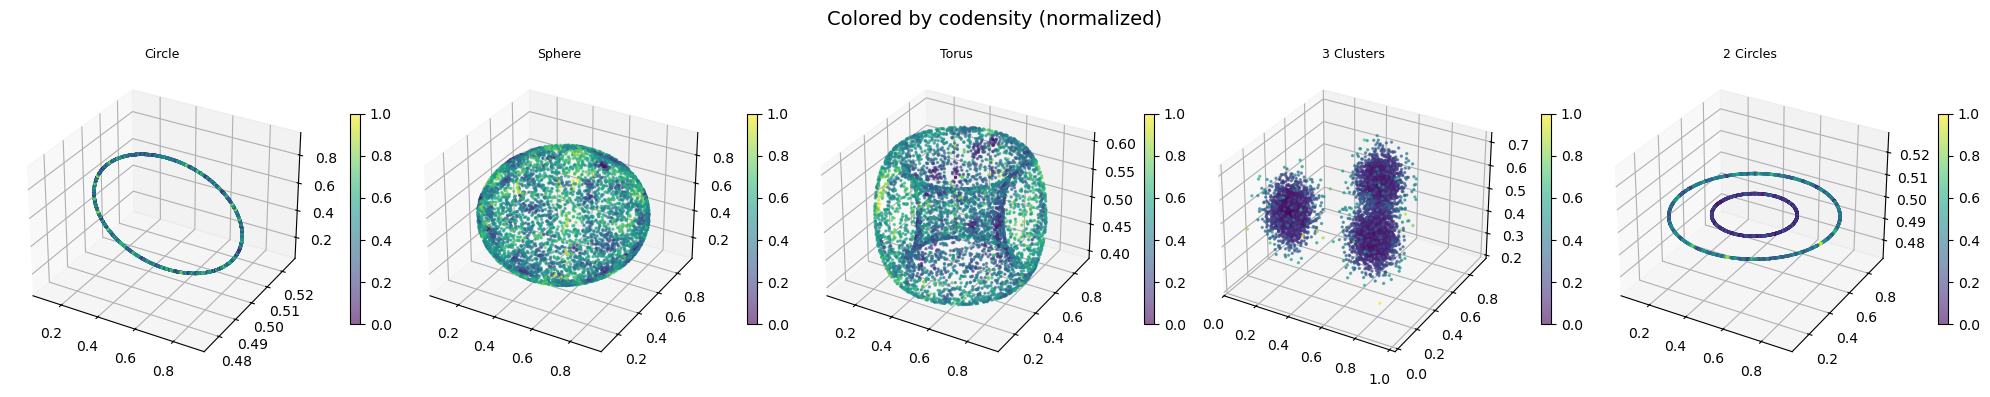

In [49]:
fig = plt.figure(figsize=(20, 4))
for c in range(n_classes):
    ax = fig.add_subplot(1, n_classes, c + 1, projection='3d')
    sc = ax.scatter(viz_data[c][:, 0], viz_data[c][:, 1], viz_data[c][:, 2],
                    s=2, alpha=0.6, c=viz_phi1[c], cmap='viridis')
    ax.set_title(class_names[c], fontsize=9)
    fig.colorbar(sc, ax=ax, fraction=0.03, pad=0.1)
fig.suptitle('Colored by codensity (normalized)', fontsize=14)
plt.tight_layout()
plt.show()

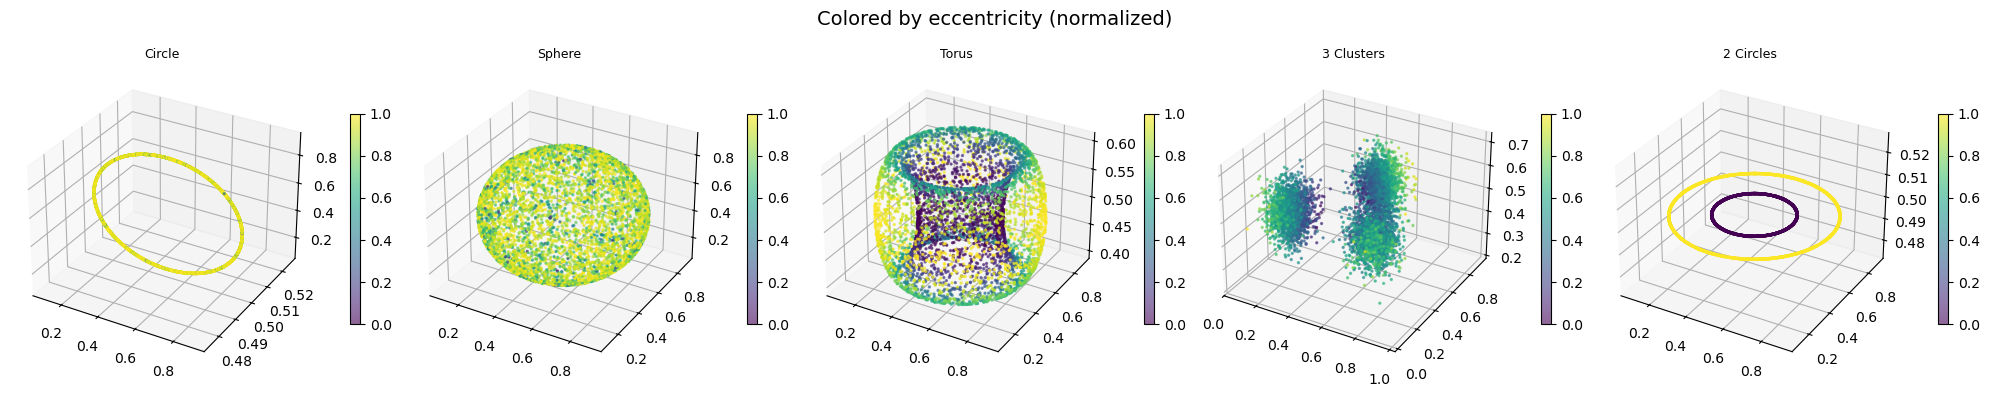

In [50]:
fig = plt.figure(figsize=(20, 4))
for c in range(n_classes):
    ax = fig.add_subplot(1, n_classes, c + 1, projection='3d')
    sc = ax.scatter(viz_data[c][:, 0], viz_data[c][:, 1], viz_data[c][:, 2],
                    s=2, alpha=0.6, c=viz_phi2[c], cmap='viridis')
    ax.set_title(class_names[c], fontsize=9)
    fig.colorbar(sc, ax=ax, fraction=0.03, pad=0.1)
fig.suptitle('Colored by eccentricity (normalized)', fontsize=14)
plt.tight_layout()
plt.show()

## Core Functions

In [51]:
def compute_codensity(points, k):
    nn = NearestNeighbors(n_neighbors=k+1).fit(points)
    dists, _ = nn.kneighbors(points)
    return dists[:, -1]

def compute_eccentricity(points):
    return np.max(pdist_sklearn(points), axis=1)


class CachedSimplexTree:
    def __init__(self, points):
        self.st = gd.AlphaComplex(points=points).create_simplex_tree()
        self._simplices = [tuple(s) for s, _ in self.st.get_simplices()]
        max_dim = max(len(s) for s in self._simplices)
        self._vert_idx = np.full((len(self._simplices), max_dim), -1, dtype=np.int32)
        for i, s in enumerate(self._simplices):
            self._vert_idx[i, :len(s)] = s

    def compute_pd(self, func_values):
        f_ext = np.append(func_values, -np.inf)
        filt_vals = np.max(f_ext[self._vert_idx], axis=1)
        for i, s in enumerate(self._simplices):
            self.st.assign_filtration(s, float(filt_vals[i]))
        self.st.make_filtration_non_decreasing()
        self.st.persistence()
        pds = []
        for dim in range(2):
            pd = self.st.persistence_intervals_in_dimension(dim)
            if pd is not None and len(pd) > 0:
                pd = pd[np.isfinite(pd[:, 1])]
            if pd is None or len(pd) == 0:
                pd = np.empty((0, 2))
            pds.append(pd)
        return tuple(pds)


def phi_star_ab(phi1, phi2, a, b):
    return np.minimum(a, 1-a) * np.maximum((phi1-b)/a, (phi2+b)/(1-a))


def safe_bottleneck(pd1, pd2, e=0.0):
    if len(pd1) == 0 and len(pd2) == 0: return 0.0
    if len(pd1) == 0: return float(np.max((pd2[:,1]-pd2[:,0])/2))
    if len(pd2) == 0: return float(np.max((pd1[:,1]-pd1[:,0])/2))
    return gd.bottleneck_distance(pd1, pd2, e)

In [52]:
def precompute_pds(Data, Phi1, Phi2, params_list):
    """Precompute PDs for a list of (type, params) specifications.
    params_list: list of (name, param_pairs) where param_pairs is list of (filtration_fn, ...)
    """
    N = len(Data)
    PDs = {name: [None]*N for name, _ in params_list}
    for i in tqdm(range(N), desc='  PDs'):
        cst = CachedSimplexTree(Data[i])
        phi1, phi2 = Phi1[i], Phi2[i]
        for name, make_filts in params_list:
            PDs[name][i] = [cst.compute_pd(f) for f in make_filts(phi1, phi2)]
    return PDs


def compute_distance_matrices(PDs, indices, n_params, e=0.0):
    m = len(indices)
    D_H0 = np.zeros((m, m))
    D_H1 = np.zeros((m, m))
    for i in tqdm(range(m), desc='  Distances', leave=False):
        for j in range(i+1, m):
            max_d0 = max_d1 = 0.0
            ii, jj = indices[i], indices[j]
            for p in range(n_params):
                d0 = safe_bottleneck(PDs[ii][p][0], PDs[jj][p][0], e)
                d1 = safe_bottleneck(PDs[ii][p][1], PDs[jj][p][1], e)
                if d0 > max_d0: max_d0 = d0
                if d1 > max_d1: max_d1 = d1
            D_H0[i,j] = D_H0[j,i] = max_d0
            D_H1[i,j] = D_H1[j,i] = max_d1
    return D_H0, D_H1


def extract_distance_blocks(D_full, train_idx, test_idx):
    return D_full[np.ix_(train_idx, train_idx)], D_full[np.ix_(test_idx, train_idx)]


def classify_knn_most_confident(D_train_list, D_test_list,
                                labels_train, labels_test, k=3):
    labels_train = np.asarray(labels_train)
    labels_test = np.asarray(labels_test)
    n_degrees = len(D_train_list)
    n_test = D_test_list[0].shape[0]
    final = np.zeros(n_test, dtype=int)
    for i in range(n_test):
        best_conf, best_pred, best_dist = -1.0, 0, np.inf
        for d in range(n_degrees):
            dists_i = D_test_list[d][i]
            k_nearest = np.argsort(dists_i)[:k]
            nn_labels = labels_train[k_nearest]
            pred = Counter(nn_labels).most_common(1)[0][0]
            conf = np.sum(nn_labels == pred) / k
            avg_d = np.mean(dists_i[k_nearest])
            if conf > best_conf or (conf == best_conf and avg_d < best_dist):
                best_conf, best_pred, best_dist = conf, pred, avg_d
        final[i] = best_pred
    return float(np.mean(final == labels_test))

## Run Experiments

In [53]:
def make_cmd_filts(phi1, phi2):
    return [(1-t)*phi1 + t*phi2 for t in t_values]

def make_md_fine_filts(phi1, phi2):
    return [phi_star_ab(phi1, phi2, a, b) for a in a_fine for b in b_fine]

def make_md_coarse_filts(phi1, phi2):
    return [phi_star_ab(phi1, phi2, a, b) for a in a_coarse for b in b_coarse]


def run_experiment(noise):
    """Full pipeline for a given noise level.
    Returns dict with cmd/mdf/mdc accuracies and timings."""
    # Generate data
    Data, Labels = [], []
    for cls_idx, gen in enumerate(generators):
        for _ in range(n_ex):
            Labels.append(cls_idx)
            Data.append(gen(n, noise=noise))
    Labels = np.array(Labels)
    N = len(Data)

    # Filtrations + normalize
    Phi1, Phi2 = [], []
    for data in Data:
        Phi1.append(compute_codensity(data, k_neighbors))
        Phi2.append(compute_eccentricity(data))
    for phi_list in [Phi1, Phi2]:
        for i in range(len(phi_list)):
            f = phi_list[i]
            fmin, fmax = f.min(), f.max()
            if fmax > fmin:
                phi_list[i] = (f - fmin) / (fmax - fmin)

    # Precompute all PDs (CST built inside, shared)
    params = [('cmd', make_cmd_filts),
              ('mdf', make_md_fine_filts),
              ('mdc', make_md_coarse_filts)]
    t0 = time.time()
    PDs = precompute_pds(Data, Phi1, Phi2, params)
    time_pds = time.time() - t0

    # Distance matrices
    all_idx = list(range(N))
    method_cfg = [
        ('cmd', n_cmd),
        ('mdf', n_md_fine),
        ('mdc', n_md_coarse),
    ]
    Ds = {}  # method -> (D_H0, D_H1)
    times_dist = {}
    for mname, nparam in method_cfg:
        t0 = time.time()
        D0, D1 = compute_distance_matrices(PDs[mname], all_idx, nparam, BOTTLENECK_E)
        times_dist[mname] = time.time() - t0
        Ds[mname] = (D0, D1)

    # 10-fold CV
    accs = {m: [] for m in ['cmd', 'mdf', 'mdc']}
    for fold in range(10):
        idx_tr, idx_te, lab_tr, lab_te = train_test_split(
            np.arange(N), Labels, train_size=0.7, stratify=Labels, random_state=42+fold)
        for mname in accs:
            D0, D1 = Ds[mname]
            blocks = [extract_distance_blocks(D, idx_tr, idx_te) for D in [D0, D1]]
            accs[mname].append(classify_knn_most_confident(
                [b[0] for b in blocks], [b[1] for b in blocks],
                lab_tr, lab_te, K_KNN))

    return accs, times_dist, time_pds

In [54]:
all_results = {}
all_times = {}

for noise in NOISE_LEVELS:
    print(f'\n{"="*60}')
    print(f'NOISE = {noise}')
    print(f'{"="*60}')
    t_total = time.time()
    accs, times_dist, time_pds = run_experiment(noise)
    t_total = time.time() - t_total
    all_results[noise] = accs
    all_times[noise] = {'pds': time_pds, 'dist': times_dist, 'total': t_total}
    for m, lbl in [('cmd','CMD'), ('mdf','MD 121'), ('mdc','MD 10')]:
        print(f'  {lbl:>6}: {np.mean(accs[m]):.2%} ± {np.std(accs[m]):.2%}')
    print(f'  time: {t_total:.0f}s')


NOISE = 0.0


  PDs: 100%|██████████| 200/200 [50:02<00:00, 15.01s/it]  


     CMD: 99.33% ± 0.82%
  MD 121: 99.83% ± 0.50%
   MD 10: 99.00% ± 1.11%
  time: 7869s

NOISE = 0.03


  PDs: 100%|██████████| 200/200 [1:00:07<00:00, 18.04s/it]


     CMD: 99.33% ± 0.82%
  MD 121: 98.50% ± 0.90%
   MD 10: 97.17% ± 2.24%
  time: 3875s

NOISE = 0.06


  PDs: 100%|██████████| 200/200 [59:06<00:00, 17.73s/it]


     CMD: 97.50% ± 1.86%
  MD 121: 94.17% ± 2.50%
   MD 10: 80.83% ± 4.23%
  time: 3666s

NOISE = 0.09


  PDs: 100%|██████████| 200/200 [59:32<00:00, 17.86s/it]


     CMD: 88.50% ± 2.83%
  MD 121: 89.00% ± 3.18%
   MD 10: 86.33% ± 2.56%
  time: 3651s

NOISE = 0.12


  PDs: 100%|██████████| 200/200 [59:37<00:00, 17.89s/it]


     CMD: 78.17% ± 2.83%
  MD 121: 81.00% ± 3.51%
   MD 10: 58.00% ± 5.21%
  time: 3638s


## Results

In [55]:
def fmt(v): return f'{np.mean(v):.2%} ± {np.std(v):.2%}'

print('=' * 75)
print(f'{"Noise":<10} {"CMD":<20} {"MD 121":<20} {"MD 10":<20}')
print('=' * 75)
for noise in NOISE_LEVELS:
    r = all_results[noise]
    print(f'{noise:<10.2f} {fmt(r["cmd"]):<20} {fmt(r["mdf"]):<20} {fmt(r["mdc"]):<20}')
print('=' * 75)

Noise      CMD                  MD 121               MD 10               
0.00       99.33% ± 0.82%       99.83% ± 0.50%       99.00% ± 1.11%      
0.03       99.33% ± 0.82%       98.50% ± 0.90%       97.17% ± 2.24%      
0.06       97.50% ± 1.86%       94.17% ± 2.50%       80.83% ± 4.23%      
0.09       88.50% ± 2.83%       89.00% ± 3.18%       86.33% ± 2.56%      
0.12       78.17% ± 2.83%       81.00% ± 3.51%       58.00% ± 5.21%      


In [56]:
np.save(f'Synthetic_{n:02d}.npy', all_results)

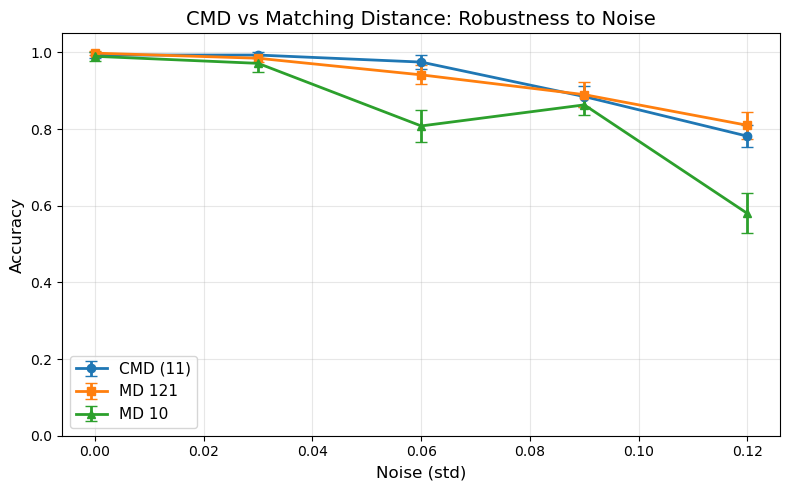

In [57]:
fig, ax = plt.subplots(figsize=(8, 5))

for m, lbl, marker in [('cmd', 'CMD (11)', 'o'),
                        ('mdf', 'MD 121', 's'),
                        ('mdc', 'MD 10', '^')]:
    means = [np.mean(all_results[nl][m]) for nl in NOISE_LEVELS]
    stds  = [np.std(all_results[nl][m]) for nl in NOISE_LEVELS]
    ax.errorbar(NOISE_LEVELS, means, yerr=stds,
                marker=marker, capsize=4, label=lbl, linewidth=2)

ax.set_xlabel('Noise (std)', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('CMD vs Matching Distance: Robustness to Noise', fontsize=14)
ax.legend(fontsize=11)
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()